# Data Preprocessing

### Step 0. Download the [Dataset_RDD2022_released_through_CRDDC2022.zip](https://figshare.com/articles/dataset/RDD2022_-_The_multi-national_Road_Damage_Dataset_released_through_CRDDC_2022/21431547/1) and unzip in the orddc2024(root) folder

In [ ]:
base_path = './RDD2022'
datasets = ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'Norway', 'United_States']
class_mapping = {'D00': 0, 'D10': 1, 'D20': 2, 'D40': 3}
file_types = ['train.txt', 'val.txt']

In [12]:
import os
import shutil
import xml.etree.ElementTree as ET
import yaml
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd

def unzip_datasets():
    for dataset in datasets:
        zip_filename = f'{dataset}.zip'
        zip_path = os.path.join(base_path, zip_filename)
        dataset_folder = os.path.join(base_path, dataset)
        
        if not os.path.exists(dataset_folder):
            print(f"Extracting {zip_path}...")
            shutil.unpack_archive(zip_path, base_path)  # Unzip the archive
            os.remove(zip_path)  # Remove the zip file after extraction
            print(f"Extracted and removed {zip_filename}")
        else:
            print(f"{dataset} is already extracted.")

def convert_to_yolo_format(bbox, img_width, img_height):
    xmin, ymin, xmax, ymax = bbox
    x_center = (xmin + xmax) / 2.0 / img_width
    y_center = (ymin + ymax) / 2.0 / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height
    return x_center, y_center, width, height

def process_dataset(dataset):
    xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')
    labels_folder_path = os.path.join(base_path, dataset, 'train', 'labels')
    os.makedirs(labels_folder_path, exist_ok=True)

    for root, dirs, files in os.walk(xml_folder_path):
        for file in files:
            if file.endswith('.xml'):
                xml_path = os.path.join(root, file)
                tree = ET.parse(xml_path)
                xml_root = tree.getroot()
                size = xml_root.find('size')
                img_width = int(size.find('width').text)
                img_height = int(size.find('height').text)

                yolo_labels = []

                for obj in xml_root.findall('object'):
                    label = obj.find('name').text
                    if label in class_mapping:
                        class_id = class_mapping[label]
                        bndbox = obj.find('bndbox')
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        bbox = (xmin, ymin, xmax, ymax)
                        yolo_bbox = convert_to_yolo_format(bbox, img_width, img_height)

                        yolo_labels.append(f"{class_id} " + " ".join(map(str, yolo_bbox)))

                if yolo_labels:
                    label_filename = file.replace('.xml', '.txt')
                    label_path = os.path.join(labels_folder_path, label_filename)

                    with open(label_path, 'w') as f:
                        f.write("\n".join(yolo_labels) + "\n")

def parse_labels(image_list, dataset):
    labels_folder_path = os.path.join(base_path, dataset, 'train', 'labels')
    
    class_counter = Counter()

    for image in image_list:
        image_name = os.path.basename(image).rsplit('.', 1)[0]
        label_path = os.path.join(labels_folder_path, image_name + '.txt')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    class_id = int(line.split()[0])
                    class_name = list(class_mapping.keys())[list(class_mapping.values()).index(class_id)]
                    class_counter[class_name] += 1
    return class_counter

def create_location_txt():
    stats = []
    for dataset in datasets:
        print(f"Processing dataset: {dataset}")
        images_folder_path = os.path.join(base_path, dataset, 'train', 'images')
        all_images = [os.path.join(images_folder_path, file) for file in os.listdir(images_folder_path) if file.endswith(('.jpg', '.png', '.jpeg'))]
        all_images_absolute = [os.path.abspath(image) for image in all_images]
        # Split the images into train+val and test (90:10 ratio)
        train_images, val_images = train_test_split(all_images_absolute, test_size=0.1, random_state=42)
        # Parse labels and calculate class distribution
        train_class_counter = parse_labels(base_path, class_mapping, train_images, dataset)
        val_class_counter = parse_labels(base_path, class_mapping, val_images, dataset)
        train_images_absolute = [image.replace("\\", "/") for image in train_images]
        val_images_absolute = [image.replace("\\", "/") for image in val_images]

        stats.append({
            'Dataset': dataset,
            'Total Images': len(all_images),
            'Train Images': len(train_images),
            'Val Images': len(val_images),
            'Train D00': train_class_counter['D00'],
            'Train D10': train_class_counter['D10'],
            'Train D20': train_class_counter['D20'],
            'Train D40': train_class_counter['D40'],
            'Val D00': val_class_counter['D00'],
            'Val D10': val_class_counter['D10'],
            'Val D20': val_class_counter['D20'],
            'Val D40': val_class_counter['D40'],
        })

        train_txt_path = os.path.join(base_path, dataset, 'train.txt')
        val_txt_path = os.path.join(base_path, dataset, 'val.txt')

        with open(train_txt_path, 'w') as f:
            for image in train_images_absolute:
                f.write(f"{image}\n")

        with open(val_txt_path, 'w') as f:
            for image in val_images_absolute:
                f.write(f"{image}\n")

        print(f"Finished processing dataset: {dataset}")

    df_stats = pd.DataFrame(stats)
    print(df_stats)
    print("All datasets processed successfully.")

def concatenate_txt_files(file_type):
    concatenated_lines = []
    total_lines = 0
    for dataset in datasets:
        file_path = os.path.join(base_path, dataset, file_type)
        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                lines = f.readlines()
                line_count = len(lines)
                total_lines += line_count
                for line in lines:
                    absolute_line = line.strip()
                    concatenated_lines.append(f"{absolute_line}\n")
                print(f"{file_path}: {line_count} lines")

    output_file_path = os.path.join(base_path, f'glob_{file_type}')
    with open(output_file_path, 'w') as f:
        f.writelines(concatenated_lines)
    
    print(f"Total lines in glob_{file_type}: {total_lines}")

def create_dataset_yaml(dataset):
    data = {
        'train': f'./{dataset}/train.txt',
        'val': f'./{dataset}/val.txt',
        'nc': 4,
        'names': {
            0: 'D00',
            1: 'D10',
            2: 'D20',
            3: 'D40'
        }
    }
    yaml_file_path = os.path.join(base_path, f'train_{dataset}.yaml')
    with open(yaml_file_path, 'w') as f:
        yaml.dump(data, f, default_flow_style=False)
    print(f"Created {yaml_file_path}")

def create_global_yaml():
    data = {
        'train': './glob_train.txt',
        'val': './glob_val.txt',
        'nc': 4,
        'names': {
            0: 'D00',
            1: 'D10',
            2: 'D20',
            3: 'D40'
        }
    }
    yaml_file_path = os.path.join(base_path, 'global_train.yaml')
    with open(yaml_file_path, 'w') as f:
        yaml.dump(data, f, default_flow_style=False)
    print(f"Created {yaml_file_path}")
### For total training
def create_total_txt_files(datasets, base_path):
    total_train_images = []
    total_val_images = []

    for dataset in datasets:
        images_folder_path = os.path.join(base_path, dataset, 'train', 'images')
        all_images = [os.path.join(images_folder_path, file)
                      for file in os.listdir(images_folder_path)
                      if file.endswith(('.jpg', '.png', '.jpeg'))]
        all_images_absolute = [os.path.abspath(image) for image in all_images]

        train_images = all_images_absolute[:-1]
        val_images = [all_images_absolute[-1]]

        train_txt_path = os.path.join(base_path, dataset, 'total_train.txt')
        val_txt_path = os.path.join(base_path, dataset, 'total_val.txt')

        with open(train_txt_path, 'w') as f:
            for image in train_images:
                image = image.replace('\\', '/')
                f.write(f"{image}\n")

        with open(val_txt_path, 'w') as f:
            image = val_images[0].replace('\\', '/')
            f.write(f"{image}\n")

        total_train_images.extend(train_images)
        total_val_images.extend(val_images)

    total_train_txt_path = os.path.join(base_path, 'total_train.txt')
    total_val_txt_path = os.path.join(base_path, 'total_val.txt')

    with open(total_train_txt_path, 'w') as f:
        for image in total_train_images:
            image = image.replace('\\', '/')
            f.write(f"{image}\n")

    with open(total_val_txt_path, 'w') as f:
        for image in total_val_images:
            image = image.replace('\\', '/')
            f.write(f"{image}\n")


def create_total_yaml_files():
    data_global = {
        'train': './total_train.txt',
        'val': './total_val.txt',
        'nc': 4,
        'names': {
            0: 'D00',
            1: 'D10',
            2: 'D20',
            3: 'D40'
        }
    }
    yaml_file_path_global = os.path.join(base_path, 'total_global_train.yaml')
    with open(yaml_file_path_global, 'w') as f:
        yaml.dump(data_global, f, default_flow_style=False)
    print(f"Created {yaml_file_path_global}")

    for dataset in datasets:
        data_dataset = {
            'train': f'./{dataset}/total_train.txt',
            'val': f'./{dataset}/total_val.txt',
            'nc': 4,
            'names': {
                0: 'D00',
                1: 'D10',
                2: 'D20',
                3: 'D40'
            }
        }
        yaml_file_path_dataset = os.path.join(base_path, dataset, f'total_{dataset}_train.yaml')
        with open(yaml_file_path_dataset, 'w') as f:
            yaml.dump(data_dataset, f, default_flow_style=False)
        print(f"Created {yaml_file_path_dataset}")

### Step 1: Unzip all datasets and remove zip files

In [3]:
unzip_datasets()

Extracting ./RDD2022\China_Drone.zip...
Extracted and removed China_Drone.zip
Extracting ./RDD2022\China_MotorBike.zip...
Extracted and removed China_MotorBike.zip
Extracting ./RDD2022\Czech.zip...
Extracted and removed Czech.zip
Extracting ./RDD2022\India.zip...
Extracted and removed India.zip
Extracting ./RDD2022\Japan.zip...
Extracted and removed Japan.zip
Extracting ./RDD2022\Norway.zip...
Extracted and removed Norway.zip
Extracting ./RDD2022\United_States.zip...
Extracted and removed United_States.zip


### Step 2: Convert XML annotations to YOLO format

In [ ]:
# Process each dataset for labels [XML to YOLO txt]
for dataset in datasets:
    process_dataset(dataset)

### Step 3: Create txt files for trining

In [13]:
create_location_txt()

Processing dataset: China_Drone
Finished processing dataset: China_Drone
Processing dataset: China_MotorBike
Finished processing dataset: China_MotorBike
Processing dataset: Czech
Finished processing dataset: Czech
Processing dataset: India
Finished processing dataset: India
Processing dataset: Japan
Finished processing dataset: Japan
Processing dataset: Norway
Finished processing dataset: Norway
Processing dataset: United_States
Finished processing dataset: United_States
           Dataset  Total Images  Train Images  Val Images  Train D00  \
0      China_Drone          2401          2160         241       1278   
1  China_MotorBike          1977          1779         198       2416   
2            Czech          2829          2546         283        885   
3            India          7706          6935         771       1416   
4            Japan         10506          9455        1051       3684   
5           Norway          8161          7344         817       7683   
6    United_

In [16]:
## Create txt Location files
for file_type in file_types:
    concatenate_txt_files(file_type)

./RDD2022\China_Drone\train.txt: 2160 lines
./RDD2022\China_MotorBike\train.txt: 1779 lines
./RDD2022\Czech\train.txt: 2546 lines
./RDD2022\India\train.txt: 6935 lines
./RDD2022\Japan\train.txt: 9455 lines
./RDD2022\Norway\train.txt: 7344 lines
./RDD2022\United_States\train.txt: 4324 lines
Total lines in glob_train.txt: 34543
./RDD2022\China_Drone\val.txt: 241 lines
./RDD2022\China_MotorBike\val.txt: 198 lines
./RDD2022\Czech\val.txt: 283 lines
./RDD2022\India\val.txt: 771 lines
./RDD2022\Japan\val.txt: 1051 lines
./RDD2022\Norway\val.txt: 817 lines
./RDD2022\United_States\val.txt: 481 lines
Total lines in glob_val.txt: 3842


### Step 4: Create YAML file

In [17]:
## Create global YAML file
create_global_yaml()

Created ./RDD2022\global_train.yaml


### + Full Dataset Training with Single Image Validation

In [ ]:
create_total_txt_files()
create_total_yaml_files()

# (OPTION) Exploratory Data Analysis

### Dataset stats

In [26]:
import os
import xml.etree.ElementTree as ET
from collections import Counter
import pandas as pd

def analyze_folder(folder_path):
    label_counter = Counter()
    bounding_box_counter = 0
    unique_classes = set()
    unique_sizes = set()
    label_file_count = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.xml'):
                label_file_count += 1
                xml_path = os.path.join(root, file)
                tree = ET.parse(xml_path)
                xml_root = tree.getroot()  
                size_element = xml_root.find('size')
                if size_element is not None:
                    width = int(size_element.find('width').text)
                    height = int(size_element.find('height').text)
                    unique_sizes.add((width, height))

                for obj in xml_root.findall('object'):
                    label = obj.find('name').text
                    label_counter[label] += 1
                    unique_classes.add(label)
                    bounding_box_counter += 1

    return label_counter, unique_classes, bounding_box_counter, label_file_count, unique_sizes

def count_image_files(folder_path):
    image_file_count = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg', '.tiff')):
                image_file_count += 1

    return image_file_count

def analyze_datasets(base_path):
    datasets = ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'Norway', 'United_States']
    summary_data = []

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')
        image_folder_path = os.path.join(base_path, dataset, 'train', 'images')
        if not os.path.exists(xml_folder_path):
            continue
        
        label_counter, unique_classes, bounding_box_counter, label_file_count, unique_sizes = analyze_folder(xml_folder_path)
        image_file_count = count_image_files(image_folder_path)
        
        dataset_summary = {
            'Dataset': dataset,
            'Number of Unique Classes': len(unique_classes),
            'Unique Classes': ', '.join(unique_classes),
            'Bounding Boxes': bounding_box_counter,
            '# of Image Files': image_file_count,
            '# of Label Files': label_file_count,
            'Unique Sizes': '; '.join([f"{w}x{h}" for w, h in unique_sizes])
        }
        
        for label, count in label_counter.items():
            dataset_summary[f'# {label}'] = count
        
        summary_data.append(dataset_summary)
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

base_path = r'.' 
summary_df = analyze_datasets(base_path)
print(summary_df)
summary_df.to_csv("stat.csv", index=False)


           Dataset  Number of Unique Classes  \
0      China_Drone                         6   
1  China_MotorBike                         5   
2            Czech                         4   
3            India                        10   
4            Japan                         7   
5           Norway                         4   
6    United_States                         4   

                                      Unique Classes  Bounding Boxes  \
0            D20, D10, D40, D00, Repair, Block crack            3840   
1                         D20, D10, D40, Repair, D00            4927   
2                                 D20, D40, D00, D10            1745   
3  D44, D20, D01, D11, D10, D40, D00, D0w0, D50, D43            8203   
4                  D20, D44, D10, D40, D00, D50, D43           24754   
5                                 D20, D40, D00, D10           11229   
6                                 D20, D40, D00, D10           11014   

   # of Image Files  # of Label Files 

In [28]:
summary_df.to_csv("stat.csv")

### Label check

Number of unique classes: 12
Unique classes: ['D20', 'D44', 'D01', 'D10', 'D11', 'D40', 'D00', 'Repair', 'Block crack', 'D0w0', 'D50', 'D43']


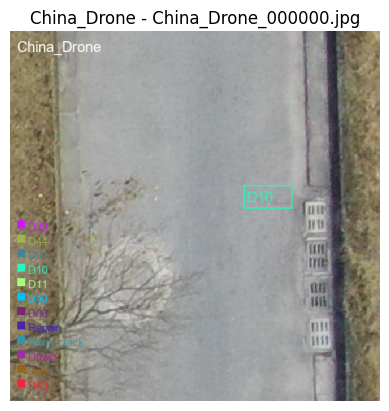

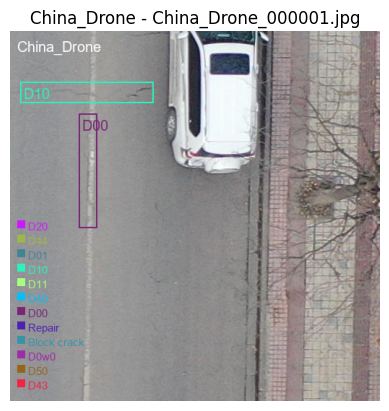

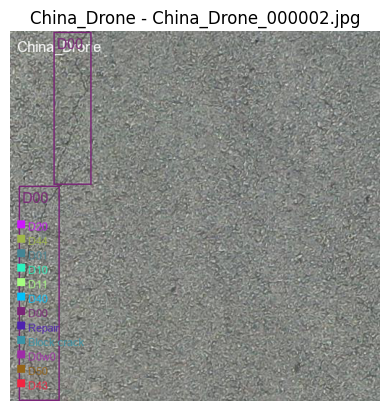

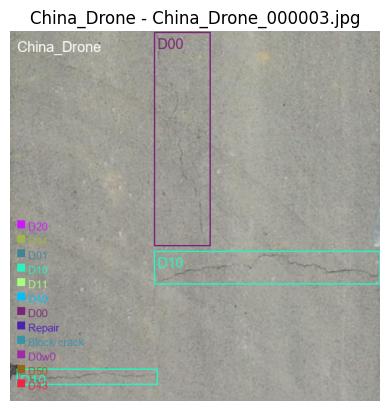

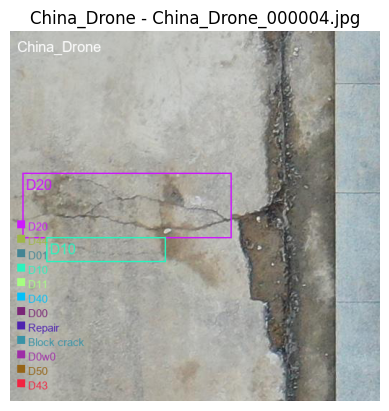

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

def get_colors(n):
    random.seed(0)
    return ["#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(n)]

def identify_unique_classes(base_path):
    datasets = ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'Norway', 'United_States']
    unique_classes = set()

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')

        if not os.path.exists(xml_folder_path):
            continue

        for root, dirs, files in os.walk(xml_folder_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_path = os.path.join(root, file)
                    tree = ET.parse(xml_path)
                    xml_root = tree.getroot()
                    for obj in xml_root.findall('object'):
                        label = obj.find('name').text
                        unique_classes.add(label)

    return list(unique_classes)

def draw_legend(draw, class_to_color, font, image_size):
    legend_x = 10
    legend_y = image_size[1] - (20 * len(class_to_color)) - 10
    for i, (cls, color) in enumerate(class_to_color.items()):
        text_y = legend_y + (i * 20)
        draw.rectangle([legend_x, text_y, legend_x + 10, text_y + 10], fill=color)
        draw.text((legend_x + 15, text_y), cls, fill=color, font=font)

def draw_bounding_boxes(image_path, xml_path, class_to_color, dataset_name):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    font_path = "C:\\Windows\\Fonts\\Arial.ttf" # Windows font
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)
    small_font = ImageFont.truetype(font_path, 15)

    draw.text((10, 10), dataset_name, fill="white", font=font)

    tree = ET.parse(xml_path)
    xml_root = tree.getroot()
    for obj in xml_root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        color = class_to_color.get(label, "red")
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
        text_bbox = draw.textbbox((xmin, ymin), label, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        text_x = xmin + 5
        text_y = ymin + 5
        draw.text((text_x, text_y), label, fill=color, font=font)

    draw_legend(draw, class_to_color, small_font, image.size)
    return image

def preview_images(base_path, class_to_color, max_files=5):
    datasets = ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'Norway', 'United_States']
    displayed_count = 0

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')
        image_folder_path = os.path.join(base_path, dataset, 'train', 'images')

        if not os.path.exists(xml_folder_path):
            continue

        for root, dirs, files in os.walk(xml_folder_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_path = os.path.join(root, file)
                    image_filename = file.replace('.xml', '.jpg')
                    image_path = os.path.join(image_folder_path, image_filename)

                    if os.path.exists(image_path):
                        annotated_image = draw_bounding_boxes(image_path, xml_path, class_to_color, dataset)

                        plt.figure()
                        plt.imshow(annotated_image)
                        plt.axis('off')
                        plt.title(f"{dataset} - {image_filename}")
                        plt.show()

                        displayed_count += 1
                        if displayed_count >= max_files:
                            return

def process_and_save_images(base_path, output_base_path, class_to_color):
    datasets = ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'Norway', 'United_States']

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')
        image_folder_path = os.path.join(base_path, dataset, 'train', 'images')

        if not os.path.exists(xml_folder_path):
            continue

        for root, dirs, files in os.walk(xml_folder_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_path = os.path.join(root, file)
                    image_filename = file.replace('.xml', '.jpg')
                    image_path = os.path.join(image_folder_path, image_filename)

                    if os.path.exists(image_path):
                        annotated_image = draw_bounding_boxes(image_path, xml_path, class_to_color, dataset)
                        output_dir = os.path.join(output_base_path, dataset, 'train', 'images')
                        os.makedirs(output_dir, exist_ok=True)
                        output_image_path = os.path.join(output_dir, image_filename)
                        annotated_image.save(output_image_path)

base_path = '.' 
output_base_path = './labeled_images'

unique_classes = identify_unique_classes(base_path)
print(f"Number of unique classes: {len(unique_classes)}")
print(f"Unique classes: {unique_classes}")

colors = get_colors(len(unique_classes))
class_to_color = {cls: color for cls, color in zip(unique_classes, colors)}

preview_images(base_path, class_to_color, max_files=5)

In [ ]:
process_and_save_images(base_path, output_base_path, class_to_color)
print(f"Annotated images have been saved in the {output_base_path} directory.")

Number of unique classes: 12
Unique classes: ['D20', 'D44', 'D01', 'D10', 'D11', 'D40', 'D00', 'Repair', 'Block crack', 'D0w0', 'D50', 'D43']


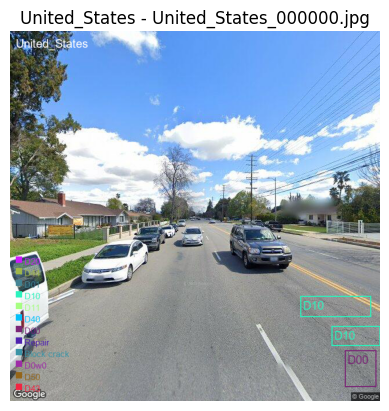

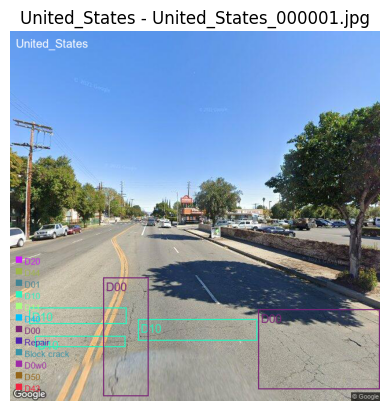

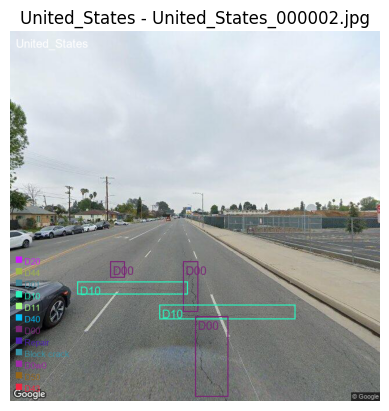

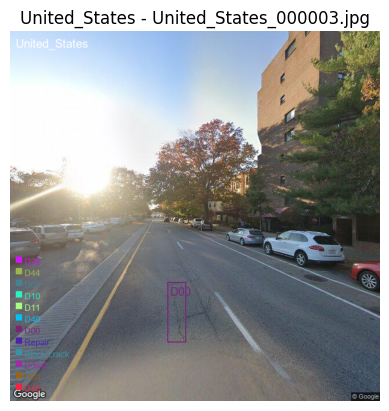

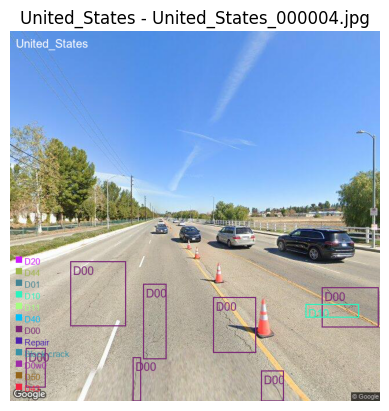

In [24]:
import os
import xml.etree.ElementTree as ET
from collections import Counter
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

def get_colors(n):
    random.seed(0)
    return ["#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(n)]

def identify_unique_classes(base_path):
    datasets = ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'Norway', 'United_States']
    unique_classes = set()

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')

        if not os.path.exists(xml_folder_path):
            continue

        for root, dirs, files in os.walk(xml_folder_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_path = os.path.join(root, file)
                    tree = ET.parse(xml_path)
                    xml_root = tree.getroot()
                    for obj in xml_root.findall('object'):
                        label = obj.find('name').text
                        unique_classes.add(label)

    return list(unique_classes)

def draw_legend(draw, class_to_color, font, image_size):
    legend_x = 10
    legend_y = image_size[1] - (20 * len(class_to_color)) - 10
    for i, (cls, color) in enumerate(class_to_color.items()):
        text_y = legend_y + (i * 20)
        draw.rectangle([legend_x, text_y, legend_x + 10, text_y + 10], fill=color)
        draw.text((legend_x + 15, text_y), cls, fill=color, font=font)

def draw_bounding_boxes(image_path, xml_path, class_to_color, dataset_name):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    font_path = "C:\\Windows\\Fonts\\Arial.ttf" # Windows font
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)
    small_font = ImageFont.truetype(font_path, 15)

    draw.text((10, 10), dataset_name, fill="white", font=font)

    tree = ET.parse(xml_path)
    xml_root = tree.getroot()
    for obj in xml_root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        color = class_to_color.get(label, "red")
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
        text_bbox = draw.textbbox((xmin, ymin), label, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        text_x = xmin + 5
        text_y = ymin + 5
        draw.text((text_x, text_y), label, fill=color, font=font)

    draw_legend(draw, class_to_color, small_font, image.size)
    return image

def preview_images(base_path, class_to_color, max_files=5):
    datasets = ['United_States']
    displayed_count = 0

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')
        image_folder_path = os.path.join(base_path, dataset, 'train', 'images')

        if not os.path.exists(xml_folder_path):
            continue

        for root, dirs, files in os.walk(xml_folder_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_path = os.path.join(root, file)
                    image_filename = file.replace('.xml', '.jpg')
                    image_path = os.path.join(image_folder_path, image_filename)

                    if os.path.exists(image_path):
                        annotated_image = draw_bounding_boxes(image_path, xml_path, class_to_color, dataset)

                        # Display the image
                        plt.figure()
                        plt.imshow(annotated_image)
                        plt.axis('off')
                        plt.title(f"{dataset} - {image_filename}")
                        plt.show()

                        displayed_count += 1
                        if displayed_count >= max_files:
                            return

def process_and_save_images(base_path, output_base_path, class_to_color):
    datasets = ['United_States']

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')
        image_folder_path = os.path.join(base_path, dataset, 'train', 'images')

        if not os.path.exists(xml_folder_path):
            continue

        for root, dirs, files in os.walk(xml_folder_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_path = os.path.join(root, file)
                    image_filename = file.replace('.xml', '.jpg')
                    image_path = os.path.join(image_folder_path, image_filename)

                    if os.path.exists(image_path):
                        annotated_image = draw_bounding_boxes(image_path, xml_path, class_to_color, dataset)
                        output_dir = os.path.join(output_base_path, dataset, 'train', 'images')
                        os.makedirs(output_dir, exist_ok=True)
                        output_image_path = os.path.join(output_dir, image_filename)
                        annotated_image.save(output_image_path)


base_path = '.'  
output_base_path = './labeled_images'


unique_classes = identify_unique_classes(base_path)
print(f"Number of unique classes: {len(unique_classes)}")
print(f"Unique classes: {unique_classes}")

colors = get_colors(len(unique_classes))
class_to_color = {cls: color for cls, color in zip(unique_classes, colors)}


preview_images(base_path, class_to_color, max_files=5)




In [25]:
process_and_save_images(base_path, output_base_path, class_to_color)
print(f"Annotated images have been saved in the {output_base_path} directory.")

Annotated images have been saved in the ./labeled_images directory.


Number of unique classes: 12
Unique classes: ['D0w0', 'D44', 'D00', 'D01', 'D50', 'D11', 'D40', 'D10', 'Block crack', 'D43', 'D20', 'Repair']


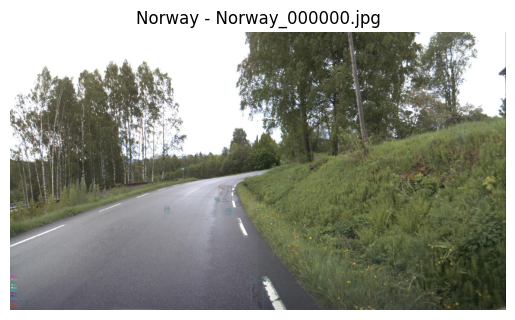

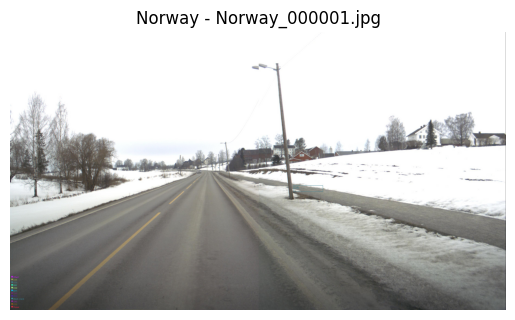

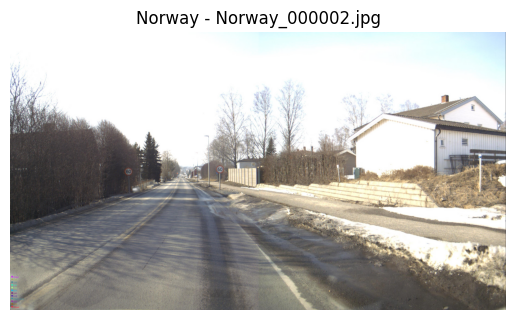

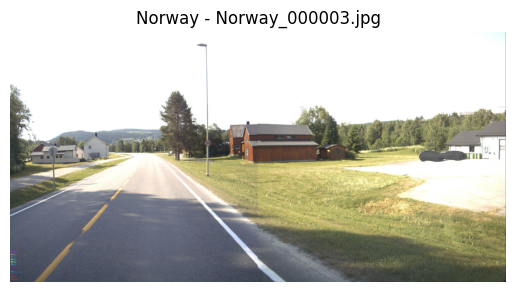

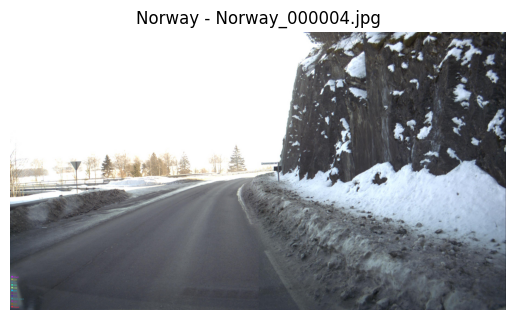

In [1]:
import os
import xml.etree.ElementTree as ET
from collections import Counter
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

def get_colors(n):
    random.seed(0)
    return ["#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(n)]

def identify_unique_classes(base_path):
    datasets = ['China_Drone', 'China_MotorBike', 'Czech', 'India', 'Japan', 'Norway', 'United_States']
    unique_classes = set()

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')

        if not os.path.exists(xml_folder_path):
            continue

        for root, dirs, files in os.walk(xml_folder_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_path = os.path.join(root, file)
                    tree = ET.parse(xml_path)
                    xml_root = tree.getroot()
                    for obj in xml_root.findall('object'):
                        label = obj.find('name').text
                        unique_classes.add(label)

    return list(unique_classes)

def draw_legend(draw, class_to_color, font, image_size):
    legend_x = 10
    legend_y = image_size[1] - (20 * len(class_to_color)) - 10
    for i, (cls, color) in enumerate(class_to_color.items()):
        text_y = legend_y + (i * 20)
        draw.rectangle([legend_x, text_y, legend_x + 10, text_y + 10], fill=color)
        draw.text((legend_x + 15, text_y), cls, fill=color, font=font)

def draw_bounding_boxes(image_path, xml_path, class_to_color, dataset_name):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    font_path = "C:\\Windows\\Fonts\\Arial.ttf"  # Windows font
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)
    small_font = ImageFont.truetype(font_path, 15)

    draw.text((10, 10), dataset_name, fill="white", font=font)

    tree = ET.parse(xml_path)
    xml_root = tree.getroot()
    for obj in xml_root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        color = class_to_color.get(label, "red")
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=2)
        text_bbox = draw.textbbox((xmin, ymin), label, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        text_x = xmin + 5
        text_y = ymin + 5
        draw.text((text_x, text_y), label, fill=color, font=font)

    draw_legend(draw, class_to_color, small_font, image.size)
    return image

def preview_images(base_path, class_to_color, max_files=5):
    datasets = ['Norway']
    displayed_count = 0

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')
        image_folder_path = os.path.join(base_path, dataset, 'train', 'images')

        if not os.path.exists(xml_folder_path):
            continue

        for root, dirs, files in os.walk(xml_folder_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_path = os.path.join(root, file)
                    image_filename = file.replace('.xml', '.jpg')
                    image_path = os.path.join(image_folder_path, image_filename)

                    if os.path.exists(image_path):
                        annotated_image = draw_bounding_boxes(image_path, xml_path, class_to_color, dataset)

                        # Display the image
                        plt.figure()
                        plt.imshow(annotated_image)
                        plt.axis('off')
                        plt.title(f"{dataset} - {image_filename}")
                        plt.show()

                        displayed_count += 1
                        if displayed_count >= max_files:
                            return

def process_and_save_images(base_path, output_base_path, class_to_color):
    datasets = ['Norway']

    for dataset in datasets:
        xml_folder_path = os.path.join(base_path, dataset, 'train', 'annotations', 'xmls')
        image_folder_path = os.path.join(base_path, dataset, 'train', 'images')

        if not os.path.exists(xml_folder_path):
            continue

        for root, dirs, files in os.walk(xml_folder_path):
            for file in files:
                if file.endswith('.xml'):
                    xml_path = os.path.join(root, file)
                    image_filename = file.replace('.xml', '.jpg')
                    image_path = os.path.join(image_folder_path, image_filename)

                    if os.path.exists(image_path):
                        annotated_image = draw_bounding_boxes(image_path, xml_path, class_to_color, dataset)
                        output_dir = os.path.join(output_base_path, dataset, 'train', 'images')
                        os.makedirs(output_dir, exist_ok=True)
                        output_image_path = os.path.join(output_dir, image_filename)
                        annotated_image.save(output_image_path)


base_path = '.'  
output_base_path = './labeled_images'

unique_classes = identify_unique_classes(base_path)
print(f"Number of unique classes: {len(unique_classes)}")
print(f"Unique classes: {unique_classes}")

colors = get_colors(len(unique_classes))
class_to_color = {cls: color for cls, color in zip(unique_classes, colors)}

preview_images(base_path, class_to_color, max_files=5)

In [38]:
process_and_save_images(base_path, output_base_path, class_to_color)
print(f"Annotated images have been saved in the {output_base_path} directory.")

Annotated images have been saved in the ./labeled_images directory.
